In [2]:
# For local usage, deactivate GPU (Otherwise error XLA version < 11.8)
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


from dataclasses import dataclass
from typing import Optional, Tuple, Callable

import dm_pix as pix
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import ott.geometry.costs as costs
from ott.geometry.pointcloud import PointCloud
from ott.solvers.linear import sinkhorn

import numpy as np
import matplotlib.pyplot as plt

from utils.datasets import emnist, celeba_attribute

/home/pacuaviva/anaconda3/envs/uot-fm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA backend failed to initialize: Unable to load CUDA. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Emnist data


In [3]:
(
    emnist_source_data,
    emnist_target_data,
    emnist_one_hot_src_labels,
    emnist_one_hot_tgt_labels,
) = emnist("train")

In [4]:
emnist_number_label = np.array(["0", "1", "8"])
emnist_letter_label = np.array(["O", "I", "B"])



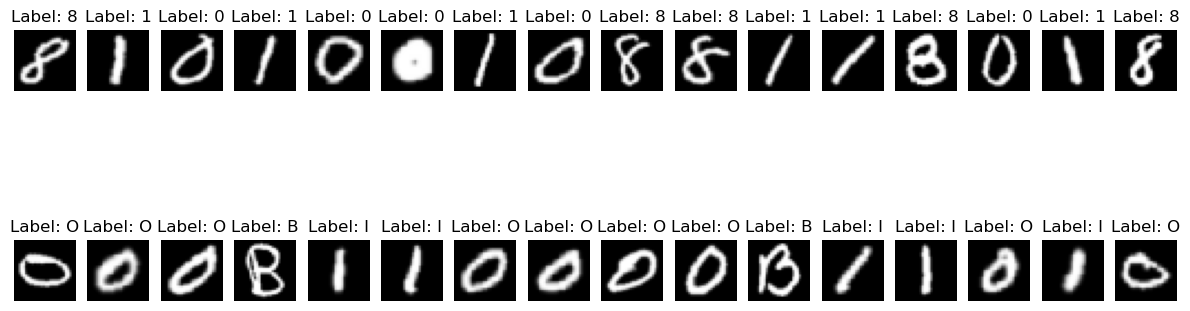

In [5]:
selected_images_idx = np.random.randint(0, 2500, size=16)

fig, axes = plt.subplots(2, len(selected_images_idx), figsize=(15, 5))

batch_emnist_source_data = np.array(
    [emnist_source_data[idx] for idx in selected_images_idx]
)
batch_emnist_src_labels = np.array(
    [
        emnist_number_label[emnist_one_hot_src_labels[idx].astype(bool)][0]
        for idx in selected_images_idx
    ]
)

batch_emnist_target_data = np.array(
    [emnist_target_data[idx] for idx in selected_images_idx]
)
batch_emnist_tgt_labels = np.array(
    [
        emnist_letter_label[emnist_one_hot_tgt_labels[idx].astype(bool)][0]
        for idx in selected_images_idx
    ]
)

for j in range(len(selected_images_idx)):
    axes[0][j].imshow(batch_emnist_source_data[j].transpose(1, 2, 0), cmap="gray")
    label = batch_emnist_src_labels[j]
    axes[0][j].set_title(f"Label: {label}")
    axes[0][j].axis("off")
    ####
    axes[1][j].imshow(batch_emnist_target_data[j].transpose(1, 2, 0), cmap="gray")
    label = batch_emnist_tgt_labels[j]
    axes[1][j].set_title(f"Label: {label}")
    axes[1][j].axis("off")

plt.show()

In [6]:
def sinkhorn_matching(
    X: np.ndarray,
    Y: np.ndarray,
    tau_a: float = 1,
    tau_b: float = 1,
    epsilon: float = 1e-2,
    cost_fn=costs.SqEuclidean(),
):
    B = X.shape[0]
    geom = PointCloud(
        jnp.reshape(X, [B, -1]),
        jnp.reshape(Y, [B, -1]),
        epsilon=epsilon,
        scale_cost="mean",
        cost_fn=cost_fn,
    )

    ot_out = sinkhorn.solve(geom, tau_a=tau_a, tau_b=tau_b)

    transition_matrix = ot_out.matrix
    return transition_matrix


def matrixF(f, X, Y=None):
    if Y is None:
        return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(X))(X)
    else:
        return jax.vmap(lambda x: jax.vmap(lambda y: f(x, y))(Y))(X)

In [7]:
def rowwise_keep_top_k(matrix, top_k: int):
    top_k_matrix = np.zeros_like(matrix)
    for i, row in enumerate(matrix):
        indices = np.argsort(row)[-top_k:]
        top_k_matrix[i, indices] = matrix[i, indices]
    return top_k_matrix


def rowwise_take_top_k(
    matrix: np.ndarray, top_k: int, labels: Optional[np.ndarray] = None
):
    """Extracts top_k values row-wise from matrixE

    Args:
        matrix (np.ndarray): distance matrix
        top_k (int): Number of top elements to take
        labels (Optional[np.ndarray], optional): labels from which to extract elements, if None defaults to extract from matrix. Defaults to None.

    Returns:
        np.ndarray: Submatrix with corresponding elements row-wise
    """
    mask = np.argsort(-matrix, axis=1)[:, :top_k]

    if labels is None:
        top_k_labels = matrix[np.arange(matrix.shape[0])[:, None], mask]
    else:
        top_k_labels = labels[mask]
    return top_k_labels

/tmp/ipykernel_35598/2023269273.py:18: DeprecationWarning: `solve` will be removed in the next release. Please use `ott.solvers.linear.solve()` instead.
  ot_out = sinkhorn.solve(geom, tau_a=tau_a, tau_b=tau_b)
/home/pacuaviva/anaconda3/envs/uot-fm/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3961: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


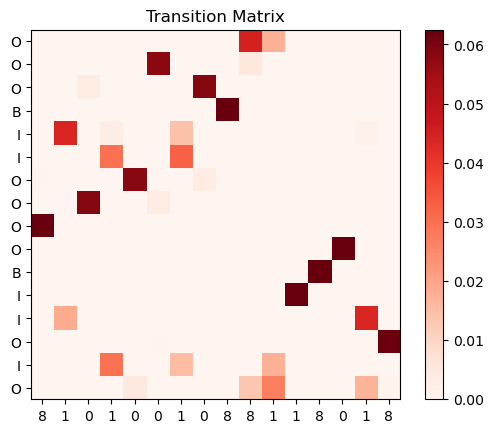

In [8]:
top_k = 3
matrix = sinkhorn_matching(batch_emnist_source_data, batch_emnist_target_data)

if top_k is None:
    plt.imshow(np.transpose(matrix), cmap="coolwarm")
else:
    plt.imshow(np.transpose((rowwise_keep_top_k(matrix, top_k))), cmap="Reds")
plt.colorbar()

# Legend label
xticks = batch_emnist_src_labels
yticks = batch_emnist_tgt_labels
plt.xticks(np.arange(len(xticks)), xticks)
plt.yticks(np.arange(len(yticks)), yticks)

plt.title("Transition Matrix")
plt.show()

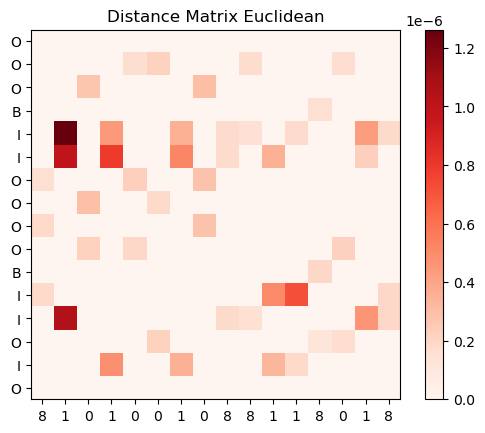

In [9]:
top_k = 3

matrix = matrixF(
    lambda x, y: 1 / jnp.sum((x - y) ** 2),
    batch_emnist_source_data,
    batch_emnist_target_data,
)

if top_k is None:
    plt.imshow(np.transpose(matrix), cmap="coolwarm")
else:
    plt.imshow(np.transpose((rowwise_keep_top_k(matrix, top_k))), cmap="Reds")
plt.colorbar()

# Legend label
xticks = batch_emnist_src_labels
yticks = batch_emnist_tgt_labels
plt.xticks(np.arange(len(xticks)), xticks)
plt.yticks(np.arange(len(yticks)), yticks)

plt.title("Distance Matrix Euclidean")
plt.show()

In [10]:
top_k_labels = rowwise_take_top_k(matrix, top_k=3, labels=batch_emnist_tgt_labels)
top_k_labels

/home/pacuaviva/anaconda3/envs/uot-fm/lib/python3.11/site-packages/jax/_src/numpy/lax_numpy.py:3961: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


array([['O', 'I', 'O'],
       ['I', 'I', 'I'],
       ['O', 'O', 'O'],
       ['I', 'I', 'I'],
       ['O', 'O', 'O'],
       ['O', 'O', 'O'],
       ['I', 'I', 'I'],
       ['O', 'O', 'O'],
       ['I', 'I', 'I'],
       ['O', 'I', 'I'],
       ['I', 'I', 'I'],
       ['I', 'I', 'I'],
       ['B', 'B', 'O'],
       ['O', 'O', 'O'],
       ['I', 'I', 'I'],
       ['I', 'I', 'I']], dtype='<U1')

/tmp/ipykernel_35598/2023269273.py:18: DeprecationWarning: `solve` will be removed in the next release. Please use `ott.solvers.linear.solve()` instead.
  ot_out = sinkhorn.solve(geom, tau_a=tau_a, tau_b=tau_b)
/tmp/ipykernel_35598/3965770025.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


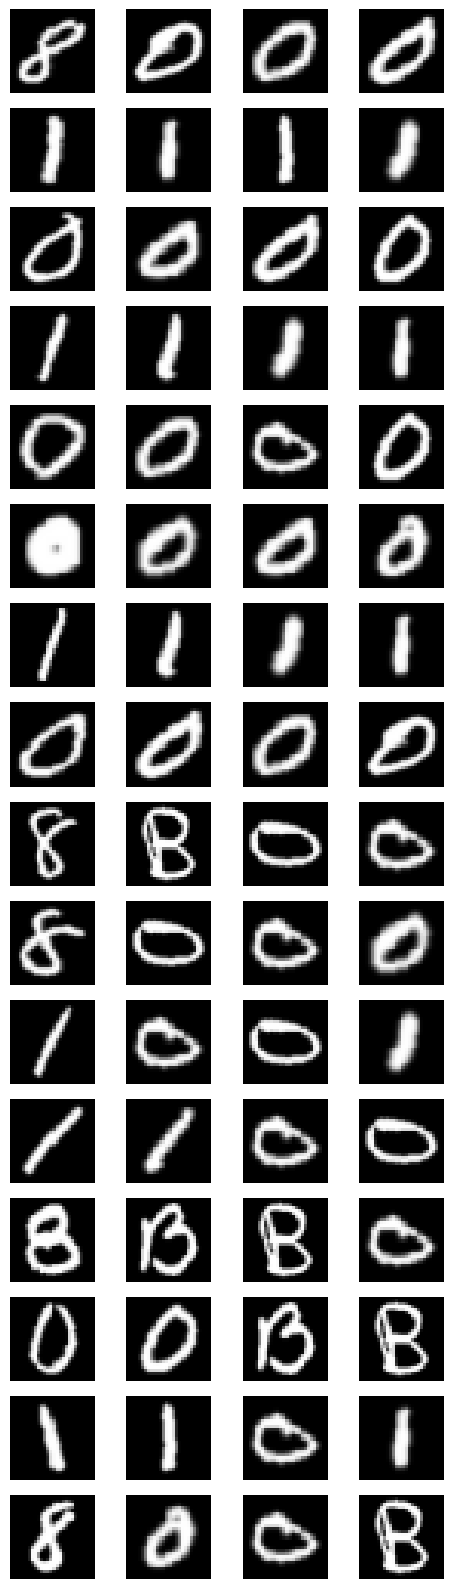

In [11]:
def fig_k_closest(
    X: np.ndarray,
    Y: Optional[np.ndarray] = None,
    top_k: int = 3,
    use_sinkhorn_matching: bool = True,
    sinkhorn_matching_kwargs: Optional[dict] = None,
    f: Callable = lambda x, y: 1 / jnp.sum(x - y) ** 2,
):
    if Y is None:
        Y = X

    if sinkhorn_matching_kwargs is None:
        sinkhorn_matching_kwargs = dict()

    if use_sinkhorn_matching:
        matrix = sinkhorn_matching(X, Y, **sinkhorn_matching_kwargs)
    else:
        matrix = matrixF(f, X=X, Y=Y)

    top_k_elements = rowwise_take_top_k(matrix, top_k=top_k, labels=Y)

    B = X.shape[0]
    fig, axes = plt.subplots(B, 1 + top_k, figsize=(5, B))
    for b in range(B):
        axes[b, 0].imshow(X[b].transpose(1, 2, 0), cmap="gray")
        axes[b, 0].axis("off")

        for k in range(top_k):
            axes[b, 1 + k].imshow(top_k_elements[b, k].transpose(1, 2, 0), cmap="gray")
            axes[b, 1 + k].axis("off")

    fig.tight_layout()
    return fig, axes


top_k = 3
fig, axes = fig_k_closest(
    X=batch_emnist_source_data,
    Y=batch_emnist_target_data,
    use_sinkhorn_matching=True,
    sinkhorn_matching_kwargs=dict(),
)

fig.show()

In [280]:
from numpy.typing import ArrayLike


def replace_chars(label: np.ndarray):
    letter_label = []
    for number in label:
        if number == "1":
            letter_label.append("I")
        elif number == "8":
            letter_label.append("B")
        elif number == "0":
            letter_label.append("O")
        else:
            raise ValueError(f"Invalid number {number} found.")
    return np.array(letter_label)


def similarity_top_k(label: ArrayLike, top_k_labels: ArrayLike) -> float:
    # The division by 2 makes it more meaningful, when using one hot encoding it makes the final calculating the "average number of matches"
    diff_fn = jax.vmap(
        lambda x, y: 1 - jnp.sum(jnp.abs(x - y), axis=1) / 2, in_axes=(0, 0)
    )  # Distance function between two features
    # ---

    similarity = diff_fn(label, top_k_labels)  # [B, k]
    similarity = jnp.mean(
        similarity, axis=1
    )  # [B,] Aggregate top_k per element, in this case uniform weighting

    similarity = jnp.mean(similarity, axis=0)  # Combine the score for all elements
    return similarity


def metrics_fn(
    matrix: np.ndarray,
    labelX: np.ndarray,
    labelY: np.ndarray,
):

    metrics = dict()
    for top_k in [1, 3, 5, 16, 32]:
        top_k_labelsY = rowwise_take_top_k(matrix, top_k=top_k, labels=labelY)
        # Assume one hot label encoding for X and Y is comparable, otherwise you must convert between them
        sim_top_k = similarity_top_k(labelX, top_k_labels=top_k_labelsY)
        metrics[f"top_{top_k}"] = sim_top_k

    for bottom_k in [1, 3, 5, 16, 32]:
        bottom_k_labelsY = rowwise_take_top_k(-matrix, top_k=bottom_k, labels=labelY)

        sim_bottom_k = similarity_top_k(labelX, top_k_labels=bottom_k_labelsY)
        metrics[f"bottom_{bottom_k}"] = sim_bottom_k

    return metrics

In [390]:
from typing import Iterable, Union, Literal
import tqdm

import itertools

import pandas as pd

from ott.solvers import linear
from ott.geometry import geometry
from numpy.typing import ArrayLike


def rowwise_correlation(matrix0, matrix1):
    centered_matrix0 = matrix0 - np.mean(matrix0, axis=1, keepdims=True)
    centered_matrix1 = matrix1 - np.mean(matrix1, axis=1, keepdims=True)

    corr = np.sum(centered_matrix0 * centered_matrix1, axis=1) / (
        np.sqrt(np.sum(centered_matrix0**2, axis=1))
        * np.sqrt(np.sum(centered_matrix1**2, axis=1))
    )
    return corr


def discrete_wasserstein_distance(
    a: ArrayLike,
    b: ArrayLike,
    cost_matrix: Optional[ArrayLike] = None,
) -> float:
    if len(a) != len(b):
        raise ValueError(
            f"Only similar length arrays may be comparend! len(a)={len(a)}!={len(b)}=len(b)"
        )

    if cost_matrix is None:
        cost_matrix = np.ones(shape=(len(a), len(a))) - np.eye(len(a))

    geom = geometry.Geometry(cost_matrix=cost_matrix)

    sol = linear.solve(
        geom,
        a=a,
        b=b,
    )

    return sol.reg_ot_cost


def matrix_comparison_metrics(matrix0: np.ndarray, matrix1: np.ndarray):
    row_correlation = rowwise_correlation(matrix0, matrix1)
    col_correlation = rowwise_correlation(jnp.transpose(matrix0), np.transpose(matrix1))
    metrics = dict(
        byrow_mean=jnp.mean(row_correlation),
        byrow_std=jnp.std(row_correlation),
        byrow_max=jnp.max(row_correlation),
        byrow_min=jnp.min(row_correlation),
        bycol_mean=jnp.mean(col_correlation),
        bycol_std=jnp.std(col_correlation),
        bycol_max=jnp.max(col_correlation),
        bycol_min=jnp.min(col_correlation),
    )

    # Aprox maximum sinkhorn problem that can nicely be solved on a local computer
    # ! SLOW & MEMORY CONSUMING. Limit when it gets used (batch_size <= 50)
    if np.prod(matrix0.shape) <= 2500:
        wasserstein0_distance = discrete_wasserstein_distance(
            matrix0.flatten(), matrix1.flatten()
        )
        metrics.update(dict(W0=wasserstein0_distance))

    return metrics


def get_batch(
    data: ArrayLike,
    label: ArrayLike,
    batch_size: int,
    key,
):
    N = data.shape[0]
    idx_batch = jax.random.randint(key, (batch_size,), 0, N)

    return data[idx_batch], label[idx_batch]


def metrics_cost_fn_sinkhorn(
    X: np.ndarray,
    labelX: np.ndarray,
    cost_fn: Optional[Union[costs.CostFn, Iterable[costs.CostFn]]],
    Y: Optional[np.ndarray] = None,
    labelY: Optional[np.ndarray] = None,
    nbatches: int = 1,
    batch_size: int = 32,
    summarize: bool = True,
    sinkhorn_matching_kwargs: Optional[dict] = None,
    seed: int = 0,
):
    if sinkhorn_matching_kwargs is None:
        sinkhorn_matching_kwargs = dict()

    if isinstance(cost_fn, costs.CostFn):
        cost_fn = [cost_fn]
    cost_fn = {cost_fni.__class__.__name__: cost_fni for cost_fni in cost_fn}

    if Y is None:  # Perform self comparison
        Y = X
        labelY = labelX

    # ---
    key = jax.random.key(seed)

    metrics = []
    comparison_metrics = []
    for _ in tqdm.tqdm(range(nbatches)):
        key, key_batchX, key_batchY = jax.random.split(key, 3)

        # Obtain batch and corresponding sinkhorn matrix
        batchX, batch_labelX = get_batch(
            X,
            labelX,
            batch_size=batch_size,
            key=key_batchX,
        )
        batchY, batch_labelY = get_batch(
            Y,
            labelY,
            batch_size=batch_size,
            key=key_batchY,
        )

        batch_matrixs = dict()
        batch_metrics = dict()

        for cost_fn_namei, cost_fni in cost_fn.items():
            # Move to sinkhorn_costfn_analysis
            matrixi = sinkhorn_matching(
                X=batchX,
                Y=batchY,
                cost_fn=cost_fni,
                **sinkhorn_matching_kwargs,
            )

            batch_metricsi = metrics_fn(
                matrixi,
                batch_labelX,
                batch_labelY,
            )

            batch_metrics[cost_fn_namei] = batch_metricsi
            batch_matrixs[cost_fn_namei] = matrixi

        # Perform pairwise comparison
        batch_comparison_metrics = dict()
        for cost_fn_namei, cost_fn_namej in itertools.combinations(cost_fn.keys(), 2):
            matrixi = batch_matrixs[cost_fn_namei]
            matrixj = batch_matrixs[cost_fn_namej]
            batch_comparison_metrics[f"{cost_fn_namei} - {cost_fn_namej}"] = (
                matrix_comparison_metrics(matrixi, matrixj)
            )

        comparison_metrics.append(batch_comparison_metrics)
        metrics.append(batch_metrics)

    # Format metrics & Comparison metrics
    # ----
    # Swap batches and cost_fn_name keys
    metrics = {
        cost_fn_namei: [metrics[i][cost_fn_namei] for i in range(len(metrics))]
        for cost_fn_namei in metrics[0]
    }
    # Concatenate fieldwise all the array corresponding to the metric for a cost_fn
    metrics = {
        cost_fn_namei: jax.tree_map(lambda *arr: jnp.stack(arr), *cost_fn_metricsi)
        for cost_fn_namei, cost_fn_metricsi in metrics.items()
    }

    metrics = {
        cost_fn_namei: pd.DataFrame.from_dict(cost_fn_metricsi)
        for cost_fn_namei, cost_fn_metricsi in metrics.items()
    }
    
    # --- 
    # Repeat same operation for comparison metrics
    comparison_metrics = {
        cost_fn_pairname: [
            comparison_metrics[i][cost_fn_pairname]
            for i in range(len(comparison_metrics))
        ]
        for cost_fn_pairname in comparison_metrics[0]
    }

    comparison_metrics = {
        cost_fn_pairname: jax.tree_map(
            lambda *arr: jnp.stack(arr), *cost_fn_pairname_metrics
        )
        for cost_fn_pairname, cost_fn_pairname_metrics in comparison_metrics.items()
    }
    comparison_metrics = {
        cost_fn_pairname: pd.DataFrame.from_dict(cost_fn_pairname_metrics)
        for cost_fn_pairname, cost_fn_pairname_metrics in comparison_metrics.items()
    }

    if summarize:
        metrics = {
            cost_fn_namei: cost_fn_metricsi.describe().rename(dict(count="nbatches"))
            for cost_fn_namei, cost_fn_metricsi in metrics.items()
        }
        comparison_metrics = {
            cost_fn_pairname: cost_fn_pairname_metrics.rename(dict(count="nbatches"))
            for cost_fn_pairname, cost_fn_pairname_metrics in comparison_metrics.items()
        }
        

    if len(metrics) == 1:
        metrics = next(iter(metrics.values()))

    return metrics, comparison_metrics

In [394]:
metrics, comparison_metrics = metrics_cost_fn_sinkhorn(
    X=emnist_source_data,
    labelX=emnist_one_hot_src_labels,
    cost_fn=[costs.SqEuclidean(), costs.Euclidean(), costs.Cosine()],
    nbatches=1,
    batch_size=128,
)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_35598/2023269273.py:18: DeprecationWarning: `solve` will be removed in the next release. Please use `ott.solvers.linear.solve()` instead.
  ot_out = sinkhorn.solve(geom, tau_a=tau_a, tau_b=tau_b)
100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


In [395]:
metrics['SqEuclidean']

,bottom_1,bottom_16,bottom_3,bottom_32,bottom_5,top_1,top_16,top_3,top_32,top_5
nbatches,1.000000,1.000000,1.0000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000
mean,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063
25%,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063
50%,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063
75%,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063
max,0.054688,0.075195,0.0625,0.069336,0.064062,0.9375,0.841797,0.914062,0.759521,0.889063


In [383]:
metrics['Euclidean']

,bottom_1,bottom_16,bottom_3,bottom_32,bottom_5,top_1,top_16,top_3,top_32,top_5
nbatches,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.111250,0.100020,0.107083,0.109214,0.104844,0.900312,0.745342,0.859635,0.654009,0.833281
std,0.108202,0.073561,0.098308,0.050583,0.093086,0.041746,0.075442,0.051048,0.069504,0.060008
min,0.000000,0.015137,0.002604,0.036865,0.010938,0.789062,0.570312,0.729167,0.499023,0.700000
25%,0.023438,0.043457,0.024089,0.068237,0.025000,0.876953,0.697998,0.830729,0.606445,0.796875
50%,0.058594,0.070801,0.067708,0.096069,0.071875,0.910156,0.761719,0.865885,0.668701,0.842187
75%,0.201172,0.131470,0.173828,0.140747,0.158984,0.929688,0.808960,0.890625,0.706238,0.871875
max,0.382812,0.279785,0.364583,0.226318,0.329688,0.968750,0.847168,0.942708,0.763428,0.932813


In [384]:
metrics['Cosine']

,bottom_1,bottom_16,bottom_3,bottom_32,bottom_5,top_1,top_16,top_3,top_32,top_5
nbatches,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.147969,0.139229,0.147135,0.133086,0.146656,0.893906,0.766357,0.860833,0.670010,0.841563
std,0.123792,0.073278,0.103323,0.051063,0.094076,0.047222,0.072185,0.054428,0.061790,0.061538
min,0.000000,0.048340,0.026042,0.069824,0.029688,0.750000,0.564453,0.710938,0.500977,0.678125
25%,0.048828,0.088867,0.070964,0.094177,0.077734,0.867188,0.740356,0.835938,0.640686,0.814453
50%,0.097656,0.115723,0.121094,0.124268,0.119531,0.902344,0.781982,0.869792,0.681274,0.851563
75%,0.232422,0.163940,0.198568,0.154175,0.188281,0.927734,0.818848,0.892578,0.716248,0.883984
max,0.429688,0.357910,0.421875,0.265381,0.403125,0.968750,0.875977,0.947917,0.765625,0.943750


In [160]:
batch_src_data_emnist, batch_src_label_emnist = get_batch(
    emnist_source_data,
    emnist_one_hot_src_labels,
    batch_size=64,
    key=jax.random.key(2),
)

batch_src_data_emnist, batch_tgt_label_emnist = get_batch(
    emnist_target_data,
    emnist_one_hot_tgt_labels,
    batch_size=64,
    key=jax.random.key(4),
)

In [169]:
matrix = sinkhorn_matching(batch_src_data_emnist, batch_src_data_emnist)

batch_tgt_top_k_label = rowwise_take_top_k(matrix, top_k=64, labels=batch_tgt_label_emnist)

/tmp/ipykernel_35598/2023269273.py:18: DeprecationWarning: `solve` will be removed in the next release. Please use `ott.solvers.linear.solve()` instead.
  ot_out = sinkhorn.solve(geom, tau_a=tau_a, tau_b=tau_b)


In [177]:
jnp.sum(batch_src_label_emnist, axis=0)

Array([22., 29., 13.], dtype=float32)

## CIFAR10


In [17]:
import tensorflow as tf

[x_train, y_train], [x_test, y_test] = tf.keras.datasets.cifar10.load_data()

In [18]:
cifar_label = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)